<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/CNN/FC2_width.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mission:

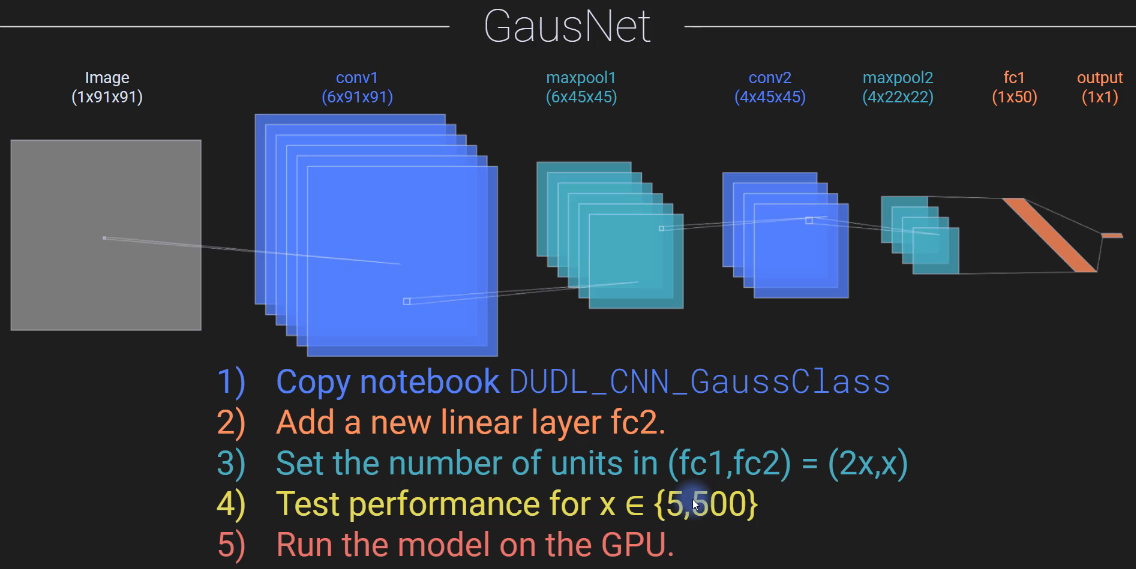

In [22]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from torchsummary import summary # provide summary info about the total count of parameters in the model

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [23]:
device

device(type='cuda', index=0)

In [24]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [25]:
# create Gaussian blurs with different widths:

nPerClass = 1000 # 1000 imgs for each category
imgSize   = 91   # 91x91 pixels

x = np.linspace(-4,4,imgSize) # [-4., ..., 4.], 91 elements in total
X,Y = np.meshgrid(x,x)
# tmp = np.meshgrid(x,x) # coordinate grid from the arrays `x` and `x`
# print(tmp, "\n") # `tmp` is a list of 2 elements, each elmt is a 91x91 matrix
# X, Y = tmp[0], tmp[1]
print(X.shape) # (91, 91)
print(Y.shape, "\n") # (91, 91)

# two different widths (arbitrary units) -> sigma:
widths = [1.8, 2.4]

# initialize images and labels:
images = torch.zeros(2*nPerClass,1,imgSize,imgSize) # grayscale
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):
  # generates random centers, sampled from a normal distribution with a mean of 0 and a standard deviation of 2
  ro = 2*np.random.randn(2) # ro: random offset, each `ro` is row vector with shape (2, )

  # Guassian:
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) ) # `i%2` returns the remainder after division (alternate between 0 and 1) -> choose 1.8 and 2.4 alternatively

  # add noise: 2D array filled with random numbers sampled from a standard normal distribution with a mean of 0 and standard deviation of 1
  G  = G + np.random.randn(imgSize,imgSize)/5 # each G shape (91, 91)

  # (91, 91) np array -> (1, 91, 91) torch tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2 # [0., 1., 0.,  ..., 1., 0., 1.]

# labels 1D vector to 2D matrix, because CNN only takes matrix:
print(labels.shape) # torch.Size([2000])
labels = labels[:,None] # vector -> matrix, because CNN only takes matrix
print(labels.shape) # torch.Size([2000, 1])

(91, 91)
(91, 91) 

torch.Size([2000])
torch.Size([2000, 1])


In [26]:
# use scikitlearn to split the data (torch tensor)
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# torch tensor -> torch Dataset obj
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# torch Dataset obj -> torch DataLoader obj
batchsize    = 32 # 32 samples in each minibatch
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [27]:
# create a class for the model
def makeTheNet(fcUnits): # introduce variable

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      # all layers in one go using nn.Sequential
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),  # output size: (91+2*1-3)/1 + 1 = 91
          nn.ReLU(),                   # note that relu is treated like a "layer"
          nn.AvgPool2d(2,2),           # mean pooling, pooling window: (2, 2), output size: 91/2 = 45
          nn.Conv2d(6,4,3,padding=1),  # output size: (45+2*1-3)/1 + 1 = 45
          nn.ReLU(),                   #
          nn.AvgPool2d(2,2),           # output size: 45/2 = 22
          nn.Flatten(),                # ㊟ vectorize conv output!
          nn.Linear(22*22*4,2*fcUnits),# output size: 2*fcUnits
          nn.ReLU(),                   # ㊟ a ReLU between the linear layers
          nn.Linear(2*fcUnits,fcUnits),# output size: fcUnits
          nn.Linear(fcUnits,1),        # output size: 1
      )

    def forward(self,x):
      return self.enc(x)

  # create the model instance
  net = gausnet()

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [28]:
# a function that trains the model

def function2trainTheModel(fcUnits):

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = makeTheNet(fcUnits)

  # ㊟ send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0)==y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # ㊟ push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # compare the following really long line of code to the training accuracy lines
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean(( (yHat>0)==y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

In [29]:
# took ~15 minutes on CPU vs. <1 min on GPU

# the range for hidden units:
numberOfLinearUnits = np.round(np.linspace(5,500,20)) # [ 5.  31.  57.  ...  370. 396. 422. 448. 474. 500.]
print(numberOfLinearUnits.shape)

# initialize results matrix
results = np.zeros((len(numberOfLinearUnits),4))

for i,nunits in enumerate(numberOfLinearUnits):
  trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel(int(nunits))
  results[i,:] = [ trainLoss[-1],testLoss[-1],trainAcc[-1],testAcc[-1] ]

(20,)


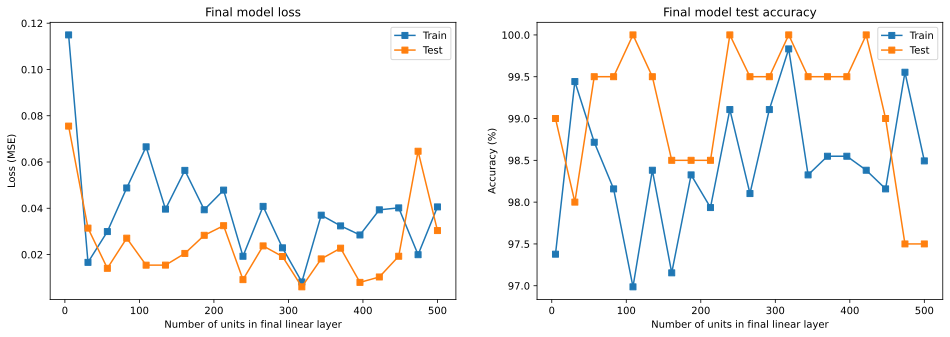

In [30]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(numberOfLinearUnits,results[:,:2],'s-')
ax[0].set_xlabel('Number of units in final linear layer')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Final model loss')
ax[0].legend(['Train','Test'])

ax[1].plot(numberOfLinearUnits,results[:,2:],'s-')
ax[1].set_xlabel('Number of units in final linear layer')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Final model test accuracy')
ax[1].legend(['Train','Test'])

plt.show()

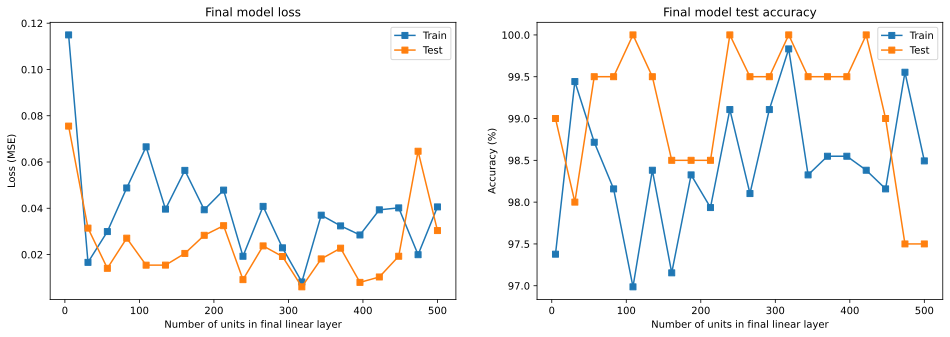

In [31]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(numberOfLinearUnits,results[:,:2],'s-')
ax[0].set_xlabel('Number of units in final linear layer')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Final model loss')
ax[0].legend(['Train','Test'])

ax[1].plot(numberOfLinearUnits,results[:,2:],'s-')
ax[1].set_xlabel('Number of units in final linear layer')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Final model test accuracy')
ax[1].legend(['Train','Test'])

plt.show()

# Conclusion:

---
If we are increasing the complexity of the model, but the model is not doing any better, then in general, we should prefer simpler models.